In [2]:
import numpy as np
import os
import pydicom
import pandas as pd
import time
from keras import backend as K
folder = '/home/vbhandaru/PycharmProjects/Capstone'

Using TensorFlow backend.


In [3]:
train = np.load(folder + '/pid lists/train_pids.npy')
val = np.load(folder + '/pid lists/val_pids.npy')
test = np.load(folder + '/pid lists/test_pids.npy')
print(train.shape, val.shape, test.shape)

traindf = pd.DataFrame({'Target': list(train[:, 0]), 'patientId': list(train[:, 1])}).sort_values(by=['patientId'])
testdf = pd.DataFrame({'Target': list(test[:, 0]), 'patientId': list(test[:, 1])}).sort_values(by=['patientId'])
valdf = pd.DataFrame({'Target': list(val[:, 0]), 'patientId': list(val[:, 1])}).sort_values(by=['patientId'])

print('Training set \n', traindf.groupby('Target').count())
print('\n Validation set \n', valdf.groupby('Target').count())
print('\n Test set \n', testdf.groupby('Target').count())

def define_target(target):
    target1 = []
    target2 = []
    for i in target:
        if i =='Lung Opacity': 
            target1.append(1)
            target2.append(1)
        if i =='No Lung Opacity / Not Normal': 
            target1.append(1)
            target2.append(2)
        if i =='Normal': 
            target1.append(0)
            target2.append(0)
    return target1, target2

target1_train, target2_train = define_target(list(traindf['Target']))
target1_val, target2_val = define_target(list(valdf['Target']))
target1_test, target2_test = define_target(list(testdf['Target']))


pids_train = list(traindf['patientId'])
pids_val = list(valdf['patientId'])
pids_test = list(testdf['patientId'])
print(len(pids_train), len(pids_val), len(pids_test))

(17978, 2) (2569, 2) (5137, 2)
Training set 
                               patientId
Target                                 
Lung Opacity                       3990
No Lung Opacity / Not Normal       8048
Normal                             5940

 Validation set 
                               patientId
Target                                 
Lung Opacity                        571
No Lung Opacity / Not Normal       1137
Normal                              861

 Test set 
                               patientId
Target                                 
Lung Opacity                       1098
No Lung Opacity / Not Normal       2315
Normal                             1724
17978 2569 5137


In [4]:
def import_image(pid, training =1):
    if training==1: fname = folder + '/Training images/' + pid + '.dcm'
    else: fname = folder + '/Test images/' + pid + '.dcm'
    im1 = pydicom.dcmread(fname).pixel_array[64:960, 64:960]
    im1 = im1[::4,::4]
    return im1
#import dcm image files using pydicom and convert to numpy array.  Crop edges.
#12 minutes
t1 = time.time()
print("...importing training images")
images_train = np.array([import_image(pid) for pid in pids_train])
print("...importing validation images")
images_val = np.array([import_image(pid) for pid in pids_val])
print("...importing test images")
images_test = np.array([import_image(pid) for pid in pids_test])
print(str(time.time()-t1), 'seconds')
print(images_train.shape, images_val.shape, images_test.shape)

...importing training images
...importing validation images
...importing test images
599.882821559906 seconds
(17978, 224, 224) (2569, 224, 224) (5137, 224, 224)


In [5]:
#Restructure data so in format for tf.image.grayscale_to_rgb
def add_dim(a):
    newlist =a.reshape(224,224,1)
    return newlist

images_train = [add_dim(images_train[i]) for i in range(len(images_train))]
images_val = [add_dim(images_val[i]) for i in range(len(images_val))]
images_test = [add_dim(images_test[i]) for i in range(len(images_test))]
images_train=np.array(images_train)
images_val=np.array(images_val)
images_test=np.array(images_test)

print(images_train.shape, images_val.shape, images_test.shape)

(17978, 224, 224, 1) (2569, 224, 224, 1) (5137, 224, 224, 1)


In [6]:
#convert from 1 channel to 3 channels
import tensorflow as tf
images_train_rgb=tf.image.grayscale_to_rgb(images_train,name=None)
images_val_rgb=tf.image.grayscale_to_rgb(images_val,name=None)
images_test_rgb=tf.image.grayscale_to_rgb(images_test,name=None)
print(images_train_rgb.shape, images_val_rgb.shape, images_test_rgb.shape)

(17978, 224, 224, 3) (2569, 224, 224, 3) (5137, 224, 224, 3)


In [7]:
#Convert tensors to numpy arrays.  6-7 minutes
t = time.time()
images_test_rgb1 = K.eval(images_test_rgb)
print(str(time.time()-t), 'seconds for test')
t = time.time()
images_train_rgb1 = K.eval(images_train_rgb)
print(str(time.time()-t), 'seconds for train')
t = time.time()
images_val_rgb1 = K.eval(images_val_rgb)
print(str(time.time()-t), 'seconds for validation')
print(type(images_train_rgb1))

88.44334006309509 seconds for test
298.7911534309387 seconds for train
43.826696157455444 seconds for validation
<class 'numpy.ndarray'>


In [8]:
print(images_test_rgb1.shape, images_train_rgb1.shape, images_val_rgb1.shape)

(5137, 224, 224, 3) (17978, 224, 224, 3) (2569, 224, 224, 3)


In [9]:
#Normalize with mean and standard deviation from ImageNet
def add_dim(a):
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]
    newlist =[]
    for j in [0,1,2]:
        newlist.append((a[:,:,j]-mean[j])/std[j])
    newlist = np.array(newlist)
    return newlist

images_train_rgb2 = [add_dim(images_train_rgb1[i]) for i in range(len(images_train_rgb1))]
images_val_rgb2 = [add_dim(images_val_rgb1[i]) for i in range(len(images_val_rgb1))]
images_test_rgb2 = [add_dim(images_test_rgb1[i]) for i in range(len(images_test_rgb1))]
print(images_train_rgb2[0].shape)

(3, 224, 224)


In [10]:
#Restructure nonstandardized data by puttingj channels first
def add_dim(a):
    newlist =[]
    for j in [0,1,2]:
        newlist.append(a[:,:,j])
    newlist = np.array(newlist)
    return newlist

images_train_rgb3 = [add_dim(images_train_rgb1[i]) for i in range(len(images_train_rgb1))]
images_val_rgb3 = [add_dim(images_val_rgb1[i]) for i in range(len(images_val_rgb1))]
images_test_rgb3 = [add_dim(images_test_rgb1[i]) for i in range(len(images_test_rgb1))]
print(images_train_rgb3[0].shape)

(3, 224, 224)


In [11]:
del(images_train)
del(images_val)
del(images_test)

del(images_train_rgb)
del(images_val_rgb)
del(images_test_rgb)

del(images_train_rgb1)
del(images_test_rgb1)
del(images_val_rgb1)

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
from torchvision import models
import sklearn
from torch.autograd import Variable
from sklearn.metrics import classification_report, accuracy_score
from torch.utils.data import DataLoader, Dataset
    
class My_dataset(Dataset):
    def __init__(self,features,labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self,idx):
        return self.features[idx],self.labels[idx]
    
    
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
#labels1 and images1 are lists

def one_epoch(labels1, images1, batch_size=100, train=1, report=0):
    start = time.time()
    criterion = torch.nn.CrossEntropyLoss()
    dataset1 = My_dataset(images1,labels1)
    data_loader1 = DataLoader(dataset1,batch_size=batch_size,shuffle=True)
    
    if train==1: model.train()
    else: model.eval()
    i=0    
    running_loss = []
    for data in data_loader1:    
        inputs, labels = data
        
        #Define as Variable()
        inputs = Variable(inputs.type(torch.FloatTensor).cuda())
        labels = Variable(labels.type(torch.LongTensor).cuda())
            
        #Calculate model output
        outputs = model(inputs)
        
        #Use model output to get predicted value of target
        _, preds = torch.max(outputs.data, 1)
        
        #Calculate loss
        loss = criterion(outputs, labels)
        l=loss.data[0].item()
        running_loss.append(l)
        
        #if training, zero gradients, calculate gradients, and update parameters
        if train==1:    
            optimizer.zero_grad()            
            loss.backward()
            optimizer.step()   
        
        #Get predicted values and actual values in dataframe
        df1 = pd.DataFrame({'Predicted': list(preds.cpu().numpy()), 'Actual': list(labels.cpu().numpy())})
        if i==0: df=df1
        else: df = pd.concat([df, df1])
        i = i+1
        
    accuracy = sum(df['Actual']==df['Predicted'])/df.shape[0]
    loss_avg = np.sum(running_loss)/len(running_loss)
    if train==0 and report==1:
        print(classification_report(df['Actual'], df['Predicted']))
        print(accuracy_score(df['Actual'], df['Predicted']))
        print(pd.crosstab(df['Actual'], df['Predicted']))
    #print(str(time.time()-start), ' seconds')
    if train==0: return accuracy, loss_avg
    
def train(_y, _x, yval, xval, nepochs=100, minepochs=10, batch_size=32, div=1, get_acc_loss=1):
    acc_train = []
    loss_train = []
    acc_val= []
    loss_val = []
    epoch = []
    k=0
    for j in range(nepochs):
        epoch.append(j+1)
        t1 = time.time()
        one_epoch(_y, _x, batch_size=batch_size)
        acc1, loss1 = one_epoch(_y, _x, batch_size=batch_size, train=0)
        acc_train.append(acc1)
        loss_train.append(loss1)
        acc2, loss2 = one_epoch(yval, xval, batch_size=batch_size, train=0)
        acc_val.append(acc2)
        loss_val.append(loss2)
            
        if j%div==0:
            print("Epoch", j, str(time.time()-t1), 'seconds')
            print('Training acc: ', acc1, ' ', 'Training loss: ', loss1, ' Validation acc: ', acc2, ' ', 'Validation loss: ', loss2)
            
        if acc1>0.99: break
    df_out = pd.DataFrame({'Epoch': epoch, 'Training Accuracy': acc_train, 'Training Loss': loss_train, 'Validation Accuracy': acc_val, 'Validation Loss': loss_val})
    df_out = df_out.set_index('Epoch')
    if get_acc_loss==1: return(df_out)

print('done')

done


In [18]:
target_train1=target2_train
images_train1=images_train_rgb2
target_val1 = target2_val
images_val1 = images_val_rgb2
target_test1=target2_test
images_test1=images_test_rgb2

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 77.53453993797302 seconds
Training acc:  0.7353988207809545   Training loss:  0.5914559028114712  Validation acc:  0.6854807318022577   Validation loss:  0.6571197748920063
Epoch 5 77.29984402656555 seconds
Training acc:  0.9151184781399488   Training loss:  0.2070469086280497  Validation acc:  0.6196963799143635   Validation loss:  1.4797077178955078
10 Epochs
              precision    recall  f1-score   support

           0       0.74      0.87      0.80      1724
           1       0.58      0.54      0.56      1098
           2       0.70      0.63      0.66      2315

   micro avg       0.69      0.69      0.69      5137
   macro avg       0.67      0.68      0.67      5137
weighted avg       0.69      0.69      0.69      5137

0.6904808253844656
Predicted     0    1     2
Actual                    
0          1493   14   217
1            79  597   422
2           436  422  1457


(0.6904808253844656, 1.5116204175149432)

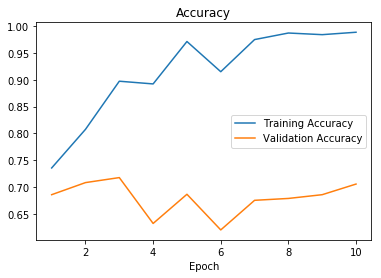

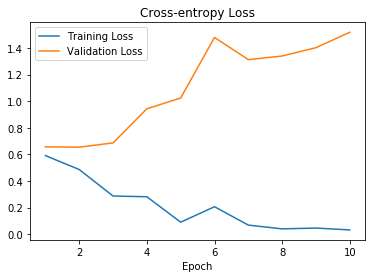

In [19]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,3)
model = resnet18.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 50.87967562675476 seconds
Training acc:  0.4448214484369785   Training loss:  1.0589541981652963  Validation acc:  0.4359673024523161   Validation loss:  1.0645729031091855
Epoch 5 50.334426164627075 seconds
Training acc:  0.4422071420625209   Training loss:  1.0592757193007079  Validation acc:  0.43441027637212926   Validation loss:  1.0628343967743863
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1724
           1       0.50      0.01      0.01      1098
           2       0.45      1.00      0.62      2315

   micro avg       0.45      0.45      0.45      5137
   macro avg       0.32      0.33      0.21      5137
weighted avg       0.31      0.45      0.28      5137

0.4512361300369866
Predicted  1     2
Actual            
0          3  1721
1          7  1091
2          4  2311


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.4512361300369866, 1.0646482639431214)

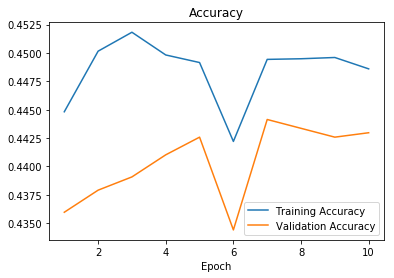

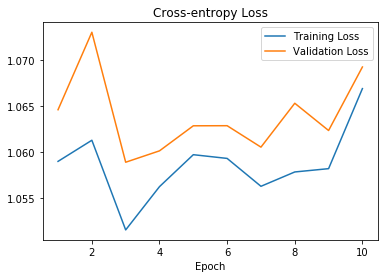

In [14]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = torch.nn.Linear(4096,3)
model = alexnet.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [15]:
#binary target
target_train1=target1_train
images_train1=images_train_rgb2
target_val1 = target1_val
images_val1 = images_val_rgb2
target_test1=target1_test
images_test1=images_test_rgb2

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 77.7478199005127 seconds
Training acc:  0.9004894871509623   Training loss:  0.2332404738563872  Validation acc:  0.8606461658232776   Validation loss:  0.3004402002710619
Epoch 5 78.31450414657593 seconds
Training acc:  0.9794192902436311   Training loss:  0.060399945928082135  Validation acc:  0.8326196963799144   Validation loss:  0.5154172496203288
8 Epochs
              precision    recall  f1-score   support

           0       0.80      0.74      0.77      1724
           1       0.87      0.91      0.89      3413

   micro avg       0.85      0.85      0.85      5137
   macro avg       0.84      0.82      0.83      5137
weighted avg       0.85      0.85      0.85      5137

0.8503017325287132
Predicted     0     1
Actual               
0          1269   455
1           314  3099


(0.8503017325287132, 0.6023613042805506)

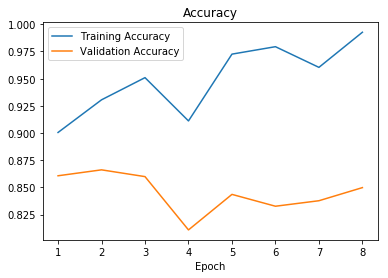

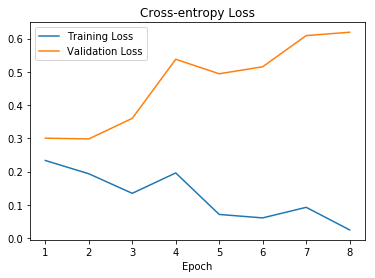

In [16]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,2)
model = resnet18.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 50.34130024909973 seconds
Training acc:  0.7483591055734787   Training loss:  0.494419282918723  Validation acc:  0.7532113662903853   Validation loss:  0.5012165716400853
Epoch 5 50.21740436553955 seconds
Training acc:  0.8537100901101347   Training loss:  0.32364619183900944  Validation acc:  0.838458544180615   Validation loss:  0.3718538895065402
              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1724
           1       0.83      0.94      0.88      3413

   micro avg       0.83      0.83      0.83      5137
   macro avg       0.84      0.77      0.79      5137
weighted avg       0.83      0.83      0.82      5137

0.8302511193303485
Predicted     0     1
Actual               
0          1041   683
1           189  3224


(0.8302511193303485, 0.3791526593036533)

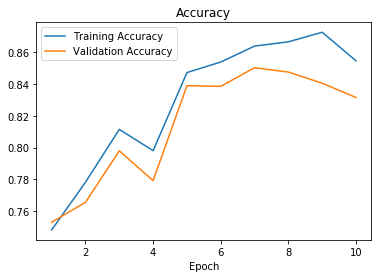

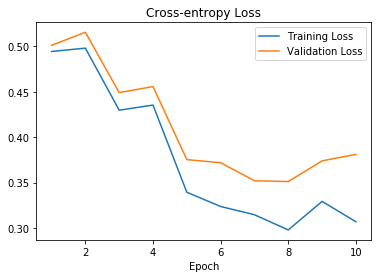

In [17]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = torch.nn.Linear(4096,2)
model = alexnet.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [ ]:
##### Repeat with non-standardized images

In [20]:
target_train1=target1_train
images_train1=images_train_rgb3
target_val1 = target1_val
images_val1 = images_val_rgb3
target_test1=target1_test
images_test1=images_test_rgb3

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 61.32348084449768 seconds
Training acc:  0.9034375347647124   Training loss:  0.23956537314316131  Validation acc:  0.8575321136629038   Validation loss:  0.3005270658083904
Epoch 5 61.49577593803406 seconds
Training acc:  0.9902102569807543   Training loss:  0.030240405463610256  Validation acc:  0.8649279875437914   Validation loss:  0.5323064192485663
6 Epochs
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      1724
           1       0.92      0.88      0.90      3413

   micro avg       0.86      0.86      0.86      5137
   macro avg       0.85      0.86      0.85      5137
weighted avg       0.87      0.86      0.87      5137

0.8647070274479268
Predicted     0     1
Actual               
0          1446   278
1           417  2996


(0.8647070274479268, 0.5146775435748863)

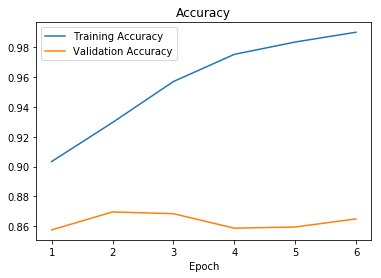

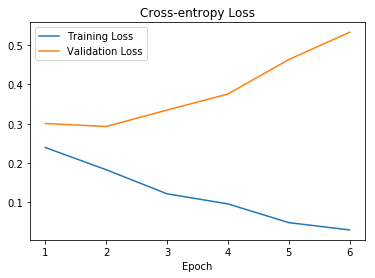

In [21]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,2)
model = resnet18.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 33.17700171470642 seconds
Training acc:  0.8033707865168539   Training loss:  0.39444546640131395  Validation acc:  0.7975866095757104   Validation loss:  0.40982275722939293
Epoch 5 33.58915615081787 seconds
Training acc:  0.8609411502948048   Training loss:  0.3288181652165817  Validation acc:  0.8431296224211755   Validation loss:  0.3689991344272355
              precision    recall  f1-score   support

           0       0.82      0.70      0.76      1724
           1       0.86      0.92      0.89      3413

   micro avg       0.85      0.85      0.85      5137
   macro avg       0.84      0.81      0.82      5137
weighted avg       0.85      0.85      0.84      5137

0.8483550710531439
Predicted     0     1
Actual               
0          1201   523
1           256  3157


(0.8483550710531439, 0.34189039755682027)

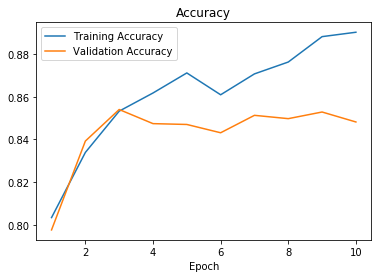

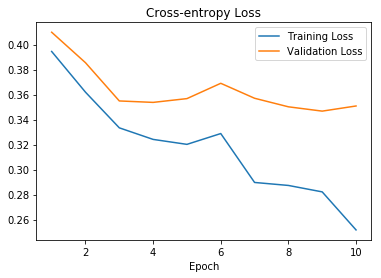

In [22]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = torch.nn.Linear(4096,2)
model = alexnet.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [23]:
target_train1=target2_train
images_train1=images_train_rgb3
target_val1 = target2_val
images_val1 = images_val_rgb3
target_test1=target2_test
images_test1=images_test_rgb3

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 61.974021911621094 seconds
Training acc:  0.7583713427522527   Training loss:  0.5623957353024296  Validation acc:  0.7065005838847801   Validation loss:  0.6322607431146834
Epoch 5 61.899492025375366 seconds
Training acc:  0.9635665813772388   Training loss:  0.0981537494278145  Validation acc:  0.697158427403659   Validation loss:  1.3364607537234272
10 Epochs
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      1724
           1       0.65      0.43      0.52      1098
           2       0.67      0.76      0.71      2315

   micro avg       0.71      0.71      0.71      5137
   macro avg       0.70      0.67      0.68      5137
weighted avg       0.71      0.71      0.70      5137

0.7078061125170333
Predicted     0    1     2
Actual                    
0          1403   20   301
1            60  470   568
2           322  230  1763


(0.7078061125170333, 1.496884648474107)

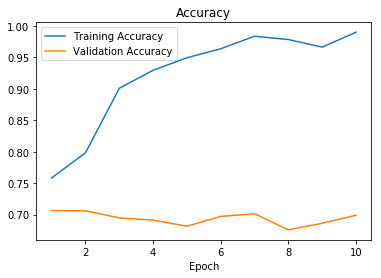

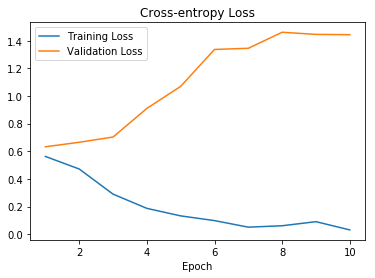

In [24]:
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = torch.nn.Linear(512,3)
model = resnet18.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 33.75286817550659 seconds
Training acc:  0.613972633218378   Training loss:  0.8311269964187595  Validation acc:  0.6119112495134293   Validation loss:  0.8498845188706009
Epoch 5 33.399592876434326 seconds
Training acc:  0.7249972188230059   Training loss:  0.633087840156623  Validation acc:  0.6539509536784741   Validation loss:  0.7411984632044663
              precision    recall  f1-score   support

           0       0.72      0.89      0.79      1724
           1       0.67      0.27      0.38      1098
           2       0.65      0.72      0.68      2315

   micro avg       0.68      0.68      0.68      5137
   macro avg       0.68      0.62      0.62      5137
weighted avg       0.68      0.68      0.65      5137

0.6778275257932646
Predicted     0    1     2
Actual                    
0          1530    3   191
1            92  296   710
2           516  143  1656


(0.6778275257932646, 0.7388719803428058)

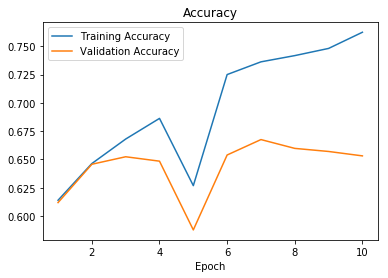

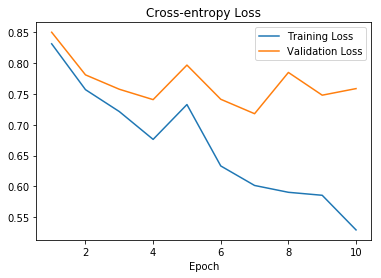

In [25]:
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = torch.nn.Linear(4096,3)
model = alexnet.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,8], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=5)
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [26]:
m = models.alexnet(pretrained=True)
m

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [27]:
m = models.resnet18(pretrained=True)
m

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 129.31930327415466 seconds
Training acc:  0.5957837356769384   Training loss:  0.8329470651853975  Validation acc:  0.5745426235889451   Validation loss:  0.8558541528972579
Epoch 2 129.44120240211487 seconds
Training acc:  0.6793302925798198   Training loss:  0.7262663639737194  Validation acc:  0.6508369015181005   Validation loss:  0.7855545863693143
Epoch 4 129.4113712310791 seconds
Training acc:  0.7144843697852932   Training loss:  0.6564477507117804  Validation acc:  0.6625145971195018   Validation loss:  0.7784267877355034
Epoch 6 129.42626810073853 seconds
Training acc:  0.7316720436088553   Training loss:  0.6304907018709861  Validation acc:  0.6368236667964189   Validation loss:  0.7977908687827028
Epoch 8 129.3669593334198 seconds
Training acc:  0.7822338413616643   Training loss:  0.5722331499077672  Validation acc:  0.6613468275593616   Validation loss:  0.8072923186384602
10 Epochs
              precision    recall  f1-score   support

           0       0.72    

(0.6558302511193304, 0.80842400670792)

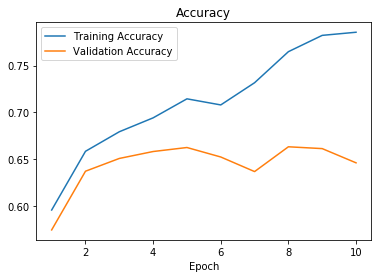

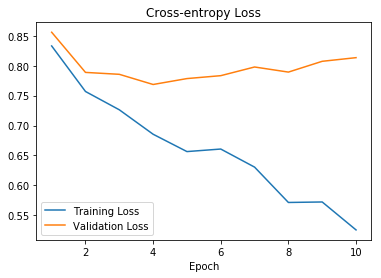

In [32]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters(): param.requires_grad=False
vgg16.classifier[6] = torch.nn.Linear(4096,3)
model = vgg16.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=2)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [33]:
target_train1=target1_train
images_train1=images_train_rgb3
target_val1 = target1_val
images_val1 = images_val_rgb3
target_test1=target1_test
images_test1=images_test_rgb3

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 129.2076859474182 seconds
Training acc:  0.8158304594504394   Training loss:  0.4121366691281787  Validation acc:  0.8065395095367848   Validation loss:  0.44396017399834997
Epoch 2 129.22957372665405 seconds
Training acc:  0.8304594504394259   Training loss:  0.3753349098022298  Validation acc:  0.7987543791358506   Validation loss:  0.43939370229656316
Epoch 4 129.32858610153198 seconds
Training acc:  0.8095449994437646   Training loss:  0.3986916156532077  Validation acc:  0.753600622810432   Validation loss:  0.5049577524632584
Epoch 6 129.28097677230835 seconds
Training acc:  0.8765713650016687   Training loss:  0.2678167672953784  Validation acc:  0.8271701050992604   Validation loss:  0.4768354410742536
Epoch 8 129.23398756980896 seconds
Training acc:  0.8939815329847591   Training loss:  0.24285762644376194  Validation acc:  0.8322304398598677   Validation loss:  0.536105225391594
10 Epochs
              precision    recall  f1-score   support

           0       0.61  

(0.7714619427681526, 0.5249003080292518)

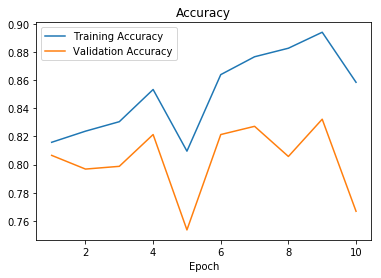

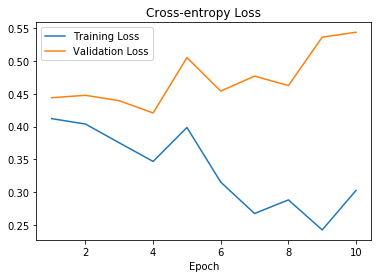

In [34]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters(): param.requires_grad=False
vgg16.classifier[6] = torch.nn.Linear(4096,2)
model = vgg16.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=2)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [37]:
target_train1=target1_train
images_train1=images_train_rgb2
target_val1 = target1_val
images_val1 = images_val_rgb2
target_test1=target1_test
images_test1=images_test_rgb2

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 155.1891803741455 seconds
Training acc:  0.8002558682834575   Training loss:  0.43989407788179946  Validation acc:  0.791358505254963   Validation loss:  0.46204497122470245
Epoch 2 154.95257806777954 seconds
Training acc:  0.8358549338079876   Training loss:  0.3672028494422122  Validation acc:  0.8162709225379525   Validation loss:  0.4205609756855317
Epoch 4 154.80023431777954 seconds
Training acc:  0.8573812437423518   Training loss:  0.3333208433143609  Validation acc:  0.8256130790190735   Validation loss:  0.42368586986889073
Epoch 6 155.8271517753601 seconds
Training acc:  0.8344643453109356   Training loss:  0.3407477753442377  Validation acc:  0.779291553133515   Validation loss:  0.4482408515465112
Epoch 8 155.16467094421387 seconds
Training acc:  0.8821337189898765   Training loss:  0.2783467862688774  Validation acc:  0.8267808485792137   Validation loss:  0.4461897400058346
10 Epochs
              precision    recall  f1-score   support

           0       0.76   

(0.8228538057231848, 0.4745989197529621)

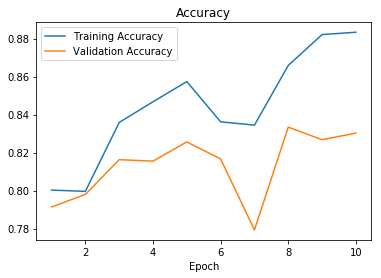

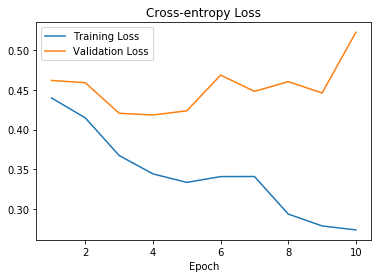

In [36]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters(): param.requires_grad=False
vgg16.classifier[6] = torch.nn.Linear(4096,2)
model = vgg16.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=2)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)

In [38]:
target_train1=target2_train
images_train1=images_train_rgb2
target_val1 = target2_val
images_val1 = images_val_rgb2
target_test1=target2_test
images_test1=images_test_rgb2

/home/vbhandaru/.local/lib/python3.5/site-packages/ipykernel_launcher.py:54: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0 155.89932370185852 seconds
Training acc:  0.5877739459339192   Training loss:  0.8477884348601209  Validation acc:  0.5698715453483846   Validation loss:  0.8611945671799742
Epoch 2 155.24133968353271 seconds
Training acc:  0.6147513627767272   Training loss:  0.7806852394151518  Validation acc:  0.600233553912028   Validation loss:  0.8237607545322843
Epoch 4 155.12838125228882 seconds
Training acc:  0.685893870285905   Training loss:  0.7107234390392847  Validation acc:  0.6449980537173998   Validation loss:  0.7842080942642542
Epoch 6 155.0326590538025 seconds
Training acc:  0.6901212593169429   Training loss:  0.6816759225100385  Validation acc:  0.6469443363176334   Validation loss:  0.7906203597416113
Epoch 8 155.7842652797699 seconds
Training acc:  0.7310045611302703   Training loss:  0.6033672101769159  Validation acc:  0.6543402101985208   Validation loss:  0.7946685765996392
10 Epochs
              precision    recall  f1-score   support

           0       0.69      

(0.6527155927584193, 0.7820076270503287)

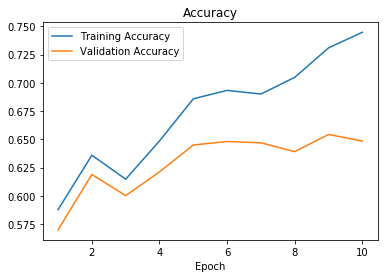

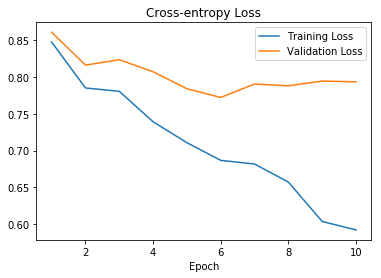

In [39]:
vgg16 = models.vgg16(pretrained=True)
for param in vgg16.features.parameters(): param.requires_grad=False
vgg16.classifier[6] = torch.nn.Linear(4096,3)
model = vgg16.cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-5)
torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 9], gamma=0.1)
final = train(target_train1, images_train1, target_val1, images_val1, nepochs=10, batch_size=32, div=2)
print(str(final.shape[0]), 'Epochs')
final[['Training Accuracy', 'Validation Accuracy']].plot(title='Accuracy')
final[['Training Loss', 'Validation Loss']].plot(title='Cross-entropy Loss')
one_epoch(target_test1,images_test1, batch_size=32, train=0, report=1)